In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 7)
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import Ridge
import statsmodels.formula.api as sm
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant
from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn import metrics
import warnings; warnings.simplefilter('ignore')

In [2]:
dataset=pd.read_csv('AQI_dataset.csv',encoding="ISO-8859-1")
df = dataset.copy()
df.head()

,stn_code,sampling_date,state,location,agency,type,so2,no2,rspm,spm,location_monitoring_station,pm2_5,date
0,150,February - M021990,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",4.8,17.4,NaN,NaN,NaN,NaN,1990-02-01
1,151,February - M021990,Andhra Pradesh,Hyderabad,NaN,Industrial Area,3.1,7.0,NaN,NaN,NaN,NaN,1990-02-01
2,152,February - M021990,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",6.2,28.5,NaN,NaN,NaN,NaN,1990-02-01
3,150,March - M031990,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",6.3,14.7,NaN,NaN,NaN,NaN,1990-03-01
4,151,March - M031990,Andhra Pradesh,Hyderabad,NaN,Industrial Area,4.7,7.5,NaN,NaN,NaN,NaN,1990-03-01


In [3]:
df.describe()

,so2,no2,rspm,spm,pm2_5
count,401096.000000,419509.000000,395520.000000,198355.000000,9314.000000
mean,10.829414,25.809623,108.832784,220.783480,40.791467
std,11.177187,18.503086,74.872430,151.395457,30.832525
min,0.000000,0.000000,0.000000,0.000000,3.000000
25%,5.000000,14.000000,56.000000,111.000000,24.000000
50%,8.000000,22.000000,90.000000,187.000000,32.000000
75%,13.700000,32.200000,142.000000,296.000000,46.000000
max,909.000000,876.000000,6307.033333,3380.000000,504.000000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 435742 entries, 0 to 435741
Data columns (total 13 columns):
stn_code                       291665 non-null object
sampling_date                  435739 non-null object
state                          435742 non-null object
location                       435739 non-null object
agency                         286261 non-null object
type                           430349 non-null object
so2                            401096 non-null float64
no2                            419509 non-null float64
rspm                           395520 non-null float64
spm                            198355 non-null float64
location_monitoring_station    408251 non-null object
pm2_5                          9314 non-null float64
date                           435735 non-null object
dtypes: float64(5), object(8)
memory usage: 43.2+ MB


In [5]:
df.isnull().sum()

stn_code                       144077
sampling_date                       3
state                               0
location                            3
agency                         149481
type                             5393
so2                             34646
no2                             16233
rspm                            40222
spm                            237387
location_monitoring_station     27491
pm2_5                          426428
date                                7
dtype: int64

### Data Cleaning

In [6]:
df.drop(['stn_code','agency','sampling_date','location_monitoring_station'],axis=1,inplace=True)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 435742 entries, 0 to 435741
Data columns (total 9 columns):
state       435742 non-null object
location    435739 non-null object
type        430349 non-null object
so2         401096 non-null float64
no2         419509 non-null float64
rspm        395520 non-null float64
spm         198355 non-null float64
pm2_5       9314 non-null float64
date        435735 non-null object
dtypes: float64(5), object(4)
memory usage: 29.9+ MB


,state,location,type,so2,no2,rspm,spm,pm2_5,date
0,Andhra Pradesh,Hyderabad,"Residential, Rural and other Areas",4.8,17.4,NaN,NaN,NaN,1990-02-01
1,Andhra Pradesh,Hyderabad,Industrial Area,3.1,7.0,NaN,NaN,NaN,1990-02-01
2,Andhra Pradesh,Hyderabad,"Residential, Rural and other Areas",6.2,28.5,NaN,NaN,NaN,1990-02-01
3,Andhra Pradesh,Hyderabad,"Residential, Rural and other Areas",6.3,14.7,NaN,NaN,NaN,1990-03-01
4,Andhra Pradesh,Hyderabad,Industrial Area,4.7,7.5,NaN,NaN,NaN,1990-03-01


In [7]:
#Finding missing values in the data set 
total = df.isnull().sum()[df.isnull().sum() != 0].sort_values(ascending = False)
percent = pd.Series(round(total/len(df)*100,2))
pd.concat([total, percent], axis=1, keys=['total_missing', 'percent'])

,total_missing,percent
pm2_5,426428,97.86
spm,237387,54.48
rspm,40222,9.23
so2,34646,7.95
no2,16233,3.73
type,5393,1.24
date,7,0.00
location,3,0.00


In [8]:
# Removing Outliers

def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

remove_outlier(df,'so2')
remove_outlier(df,'no2')
remove_outlier(df,'rspm')
remove_outlier(df,'spm')


,state,location,type,so2,no2,rspm,spm,pm2_5,date
11,Andhra Pradesh,Hyderabad,"Residential, Rural and other Areas",3.9,14.1,NaN,133.0,NaN,1990-06-01
12,Andhra Pradesh,Hyderabad,Industrial Area,5.6,11.8,NaN,82.0,NaN,1990-06-01
13,Andhra Pradesh,Hyderabad,"Residential, Rural and other Areas",3.3,19.3,NaN,111.0,NaN,1990-06-01
14,Andhra Pradesh,Hyderabad,"Residential, Rural and other Areas",3.9,8.2,NaN,118.0,NaN,1990-07-01
15,Andhra Pradesh,Hyderabad,"Residential, Rural and other Areas",3.5,12.1,NaN,135.0,NaN,1990-07-01
...,...,...,...,...,...,...,...,...,...
431453,West Bengal,Kolkata,Industrial Area,8.0,54.0,106.0,50.0,NaN,2013-03-14
431454,West Bengal,Kolkata,Industrial Area,9.0,49.0,123.0,54.0,NaN,2013-03-19
431455,West Bengal,Kolkata,Industrial Area,7.0,47.0,107.0,50.0,NaN,2013-03-22
431456,West Bengal,Kolkata,Industrial Area,7.0,50.0,130.0,53.0,NaN,2013-03-27


In [9]:
#state wise distribution of all the major pollutants i.e so2, no2, rspm, spm, pm2_5

df.groupby('state')[['spm','pm2_5','rspm','so2','no2']].mean()

,spm,pm2_5,rspm,so2,no2
state,,,,,
Andhra Pradesh,200.260378,NaN,78.182824,7.284845,21.704451
Arunachal Pradesh,NaN,NaN,76.629213,3.179104,5.469697
Assam,153.355386,NaN,93.724912,6.723263,14.793691
Bihar,276.917416,NaN,123.705176,19.381476,36.575525
Chandigarh,206.056150,NaN,96.587079,2.676986,18.619404
Chhattisgarh,231.290969,NaN,126.472399,12.846609,24.815961
Dadra & Nagar Haveli,170.545024,30.511628,76.536530,8.939587,18.293959
Daman & Diu,145.681416,27.886364,73.749431,8.192958,16.168926
Delhi,399.402088,95.113208,196.639771,8.737273,53.489147


In [10]:
# filling missing values with mean of the data
by_State=df.groupby('state')

def impute_mean(series):
    return series.fillna(series.mean())

df['rspm']=by_State['rspm'].transform(impute_mean)
df['so2']=by_State['so2'].transform(impute_mean)
df['no2']=by_State['no2'].transform(impute_mean)
df['spm']=by_State['spm'].transform(impute_mean)
df['pm2_5']=by_State['pm2_5'].transform(impute_mean)

In [11]:
#Missing values being filled in columns
for col in df.columns.values:
    if df[col].isnull().sum() == 0:
        continue
    if col == 'date':
        guess_values = df.groupby('state')['date'].apply(lambda x: x.mode().max())
    elif col=='type':
        guess_values = df.groupby('state')['type'].apply(lambda x: x.mode().max())
    else:
        guess_values = df.groupby('state')['location'].apply(lambda x: x.mode().max())
df.head()

,state,location,type,so2,no2,rspm,spm,pm2_5,date
0,Andhra Pradesh,Hyderabad,"Residential, Rural and other Areas",4.8,17.4,78.182824,200.260378,NaN,1990-02-01
1,Andhra Pradesh,Hyderabad,Industrial Area,3.1,7.0,78.182824,200.260378,NaN,1990-02-01
2,Andhra Pradesh,Hyderabad,"Residential, Rural and other Areas",6.2,28.5,78.182824,200.260378,NaN,1990-02-01
3,Andhra Pradesh,Hyderabad,"Residential, Rural and other Areas",6.3,14.7,78.182824,200.260378,NaN,1990-03-01
4,Andhra Pradesh,Hyderabad,Industrial Area,4.7,7.5,78.182824,200.260378,NaN,1990-03-01


### Derivation for Individual Pollutant Index and AQI

The AQI is an index for reporting daily air quality. It tells you how clean or polluted your air is, and what associated health effects might be a concern for you. The AQI focuses on health effects you may experience within a few hours or days after breathing polluted air. EPA
calculates the AQI for five major air pollutants regulated by the Clean Air Act: groundlevel ozone, particle pollution Air quality directly affects (also known as particulate our quality of life. matter), carbon monoxide, sulfur dioxide, and nitrogen dioxide. For each of these
pollutants, EPA has established national air quality standards to protect public health.

AQI is calculated on the range of 0-500, we are scaling the values according to the AQI calculation formula


###   AQI = AQI_{min} +  \frac{PM_{Obs}-PM_{Min}}{AQI_{Max}-AQI_{Min}}{(PM_{Max}-PM_{Min})}

#### Function to calculate so2 individual pollutant index(si)
The index category for SO2 is scaled between 0-1600. So on applying formula which is used to calculate AQI

In [12]:
#Function to calculate no2 individual pollutant index(si)

def calculate_si(so2):
    si=0
    if (so2<=40):
        si= so2*(50/40)
    elif (so2>40 and so2<=80):
        si= 50+(so2-40)*(50/40)
    elif (so2>80 and so2<=380):
        si= 100+(so2-80)*(100/300)
    elif (so2>380 and so2<=800):
        si= 200+(so2-380)*(100/420)
    elif (so2>800 and so2<=1600):
        si= 300+(so2-800)*(100/800)
    elif (so2>1600):
        si= 400+(so2-1600)*(100/800)
    return si
df['si']=df['so2'].apply(calculate_si)
df1= df[['so2','si']]
df1.head()

,so2,si
0,4.8,6.000
1,3.1,3.875
2,6.2,7.750
3,6.3,7.875
4,4.7,5.875


#### Function to calculate no2 individual pollutant index(ni)
The index category for NO2 is scaled between 0-400. So on applying formula which is used to calculate AQI

In [13]:
#Function to calculate no2 individual pollutant index(ni)
def calculate_ni(no2):
    ni=0
    if(no2<=40):
        ni= no2*50/40
    elif(no2>40 and no2<=80):
        ni= 50+(no2-40)*(50/40)
    elif(no2>80 and no2<=180):
        ni= 100+(no2-80)*(100/100)
    elif(no2>180 and no2<=280):
        ni= 200+(no2-180)*(100/100)
    elif(no2>280 and no2<=400):
        ni= 300+(no2-280)*(100/120)
    else:
        ni= 400+(no2-400)*(100/120)
    return ni
df['ni']=df['no2'].apply(calculate_ni)
df1= df[['no2','ni']]
df1.head()

,no2,ni
0,17.4,21.750
1,7.0,8.750
2,28.5,35.625
3,14.7,18.375
4,7.5,9.375


### Function to calculate rspm individual pollutant index(rpi)
The index category for rspm is scaled between 0-400. So on applying formula which is used to calculate AQI

In [14]:
#Function to calculate rspm individual pollutant index(rpi)
def calculate_(rspm):
    rpi=0
    if(rpi<=30):
        rpi=rpi*50/30
    elif(rpi>30 and rpi<=60):
        rpi=50+(rpi-30)*50/30
    elif(rpi>60 and rpi<=90):
        rpi=100+(rpi-60)*100/30
    elif(rpi>90 and rpi<=120):
        rpi=200+(rpi-90)*100/30
    elif(rpi>120 and rpi<=250):
        rpi=300+(rpi-120)*(100/130)
    else:
        rpi=400+(rpi-250)*(100/130)
    return rpi
df['rpi']=df['rspm'].apply(calculate_si)
df1= df[['rspm','rpi']]
df1.head()

,rspm,rpi
0,78.182824,97.72853
1,78.182824,97.72853
2,78.182824,97.72853
3,78.182824,97.72853
4,78.182824,97.72853


### Function to calculate spm individual pollutant index(spi)
The index category for rspm is scaled between 0-430. So on applying formula which is used to calculate AQI

In [15]:
#Function to calculate spm individual pollutant index(spi)
def calculate_spi(spm):
    spi=0
    if(spm<=50):
        spi=spm*50/50
    elif(spm>50 and spm<=100):
        spi=50+(spm-50)*(50/50)
    elif(spm>100 and spm<=250):
        spi= 100+(spm-100)*(100/150)
    elif(spm>250 and spm<=350):
        spi=200+(spm-250)*(100/100)
    elif(spm>350 and spm<=430):
        spi=300+(spm-350)*(100/80)
    else:
        spi=400+(spm-430)*(100/430)
    return spi
df['spi']=df['spm'].apply(calculate_spi)
df1= df[['spm','spi']]
df1.head()

,spm,spi
0,200.260378,166.840252
1,200.260378,166.840252
2,200.260378,166.840252
3,200.260378,166.840252
4,200.260378,166.840252


### Function to calculate pm2_5 individual pollutant index(pmi)
The index category for rspm is scaled between 0-430. So on applying formula which is used to calculate AQI

In [16]:
#Function to calculate pm2_5 individual pollutant index(pmi)
def calculate_pmi(pm2_5):
    pmi=0
    if(pm2_5<=50):
        pmi=pm2_5*(50/50)
    elif(pm2_5>50 and pm2_5<=100):
        pmi=50+(pm2_5-50)*(50/50)
    elif(pm2_5>100 and pm2_5<=250):
        pmi= 100+(pm2_5-100)*(100/150)
    elif(pm2_5>250 and pm2_5<=350):
        pmi=200+(pm2_5-250)*(100/100)
    elif(pm2_5>350 and pm2_5<=450):
        pmi=300+(pm2_5-350)*(100/100)
    else:
        pmi=400+(pm2_5-430)*(100/80)
    return pmi
df['pmi']=df['pm2_5'].apply(calculate_pmi)
df1= df[['pm2_5','pmi']]
df1.tail()

,pm2_5,pmi
435737,64.890625,64.890625
435738,64.890625,64.890625
435739,NaN,NaN
435740,NaN,NaN
435741,NaN,NaN


### Function to calculate the air quality index (AQI) of every data value its is calculated as per indian govt standards
The purpose of the AQI is to help you understand what
local air quality means to your health. Also it is scaled from 0 to 500.

In [17]:
#function to calculate the air quality index (AQI) of every data value
#its is calculated as per indian govt standards
def calculate_aqi(si,ni,spi,rpi):
    aqi=0
    if(si>ni and si>spi and si>rpi):
        aqi=si
    if(spi>si and spi>ni and spi>rpi):
        aqi=spi
    if(ni>si and ni>spi and ni>rpi):
        aqi=ni
    if(rpi>si and rpi>ni and rpi>spi):
        aqi=rpi
    return aqi
df['AQI']=df.apply(lambda x:calculate_aqi(x['si'],x['ni'],x['spi'],x['rpi']),axis=1)
df1= df[['state','si','ni','rpi','spi','AQI']]
df1.head()


,state,si,ni,rpi,spi,AQI
0,Andhra Pradesh,6.000,21.750,97.72853,166.840252,166.840252
1,Andhra Pradesh,3.875,8.750,97.72853,166.840252,166.840252
2,Andhra Pradesh,7.750,35.625,97.72853,166.840252,166.840252
3,Andhra Pradesh,7.875,18.375,97.72853,166.840252,166.840252
4,Andhra Pradesh,5.875,9.375,97.72853,166.840252,166.840252


###    <p style="text-align: center;">1.5 Exploratory Data Analysis (EDA)  <a id='eda'></a>


### Graph Overview:- Visualization of AQI across india (Year-wise)

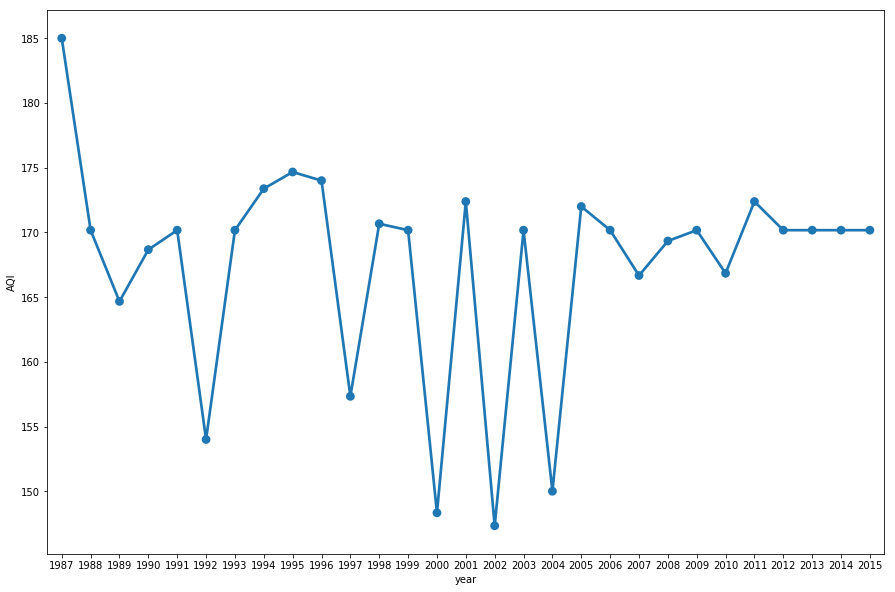

In [18]:
#Visualization of AQI across india 

df['date'] = pd.to_datetime(df['date'],format='%Y-%m-%d') # date parse
df['year'] = df['date'].dt.year # year
df['year'] = df['year'].fillna(0.0).astype(int)
df = df[(df['year']>0)]

dx = df[['AQI','year','state']].groupby(["year"]).median().reset_index().sort_values(by='year',ascending=False)
f,ax=plt.subplots(figsize=(15,10))
sns.pointplot(x='year', y='AQI', data=dx)
plt.show()

### Table Overview:- Exploring air pollution state-wise 

In [19]:
#Exploring air pollution state-wise
df.fillna(0.0,inplace=True)
states=df.groupby(['state','location'],as_index=False).mean()
state=states.groupby(['state'],as_index=False).mean()
state

,state,so2,no2,rspm,spm,pm2_5,si,ni,rpi,spi,pmi,AQI,year
0,Andhra Pradesh,7.005150,17.705235,73.718197,197.085630,0.000000,8.740983,22.091476,84.591479,165.285154,0.000000,165.901863,2011.649547
1,Arunachal Pradesh,3.179104,5.469697,76.629213,0.000000,0.000000,3.973881,6.837121,84.939295,0.000000,0.000000,0.000000,2014.666667
2,Assam,6.297072,14.122107,79.860142,141.421396,0.000000,7.871341,17.652233,81.545275,126.050825,0.000000,126.577559,2011.302031
3,Bihar,33.321814,42.324845,123.705176,281.948937,0.000000,40.939075,52.833105,113.740949,233.301398,0.000000,234.617619,1997.542211
4,Chandigarh,2.676986,18.619404,96.587079,206.056150,0.000000,3.346232,23.271826,96.646110,174.128162,0.000000,174.262893,2009.221831
5,Chhattisgarh,11.964182,25.336867,127.909085,233.774753,0.000000,14.955227,31.670710,114.758968,192.639060,0.000000,192.897348,2010.187112
6,Dadra & Nagar Haveli,8.037770,15.451606,76.720537,149.020211,30.511628,10.047213,19.314507,91.353542,132.029920,30.511628,138.964052,2004.342285
7,Daman & Diu,7.339134,12.615693,73.749431,127.996169,27.886364,9.173918,15.769616,89.039467,114.877290,27.886364,124.524897,2000.611876
8,Delhi,8.737273,53.489147,196.639771,399.402088,95.113208,10.908845,65.928540,136.469616,332.640733,94.889452,332.829348,2006.803415
9,Goa,7.424731,11.790294,59.443098,57.524474,18.995716,9.254478,14.737801,69.158024,56.055605,18.984334,79.622941,2011.932261


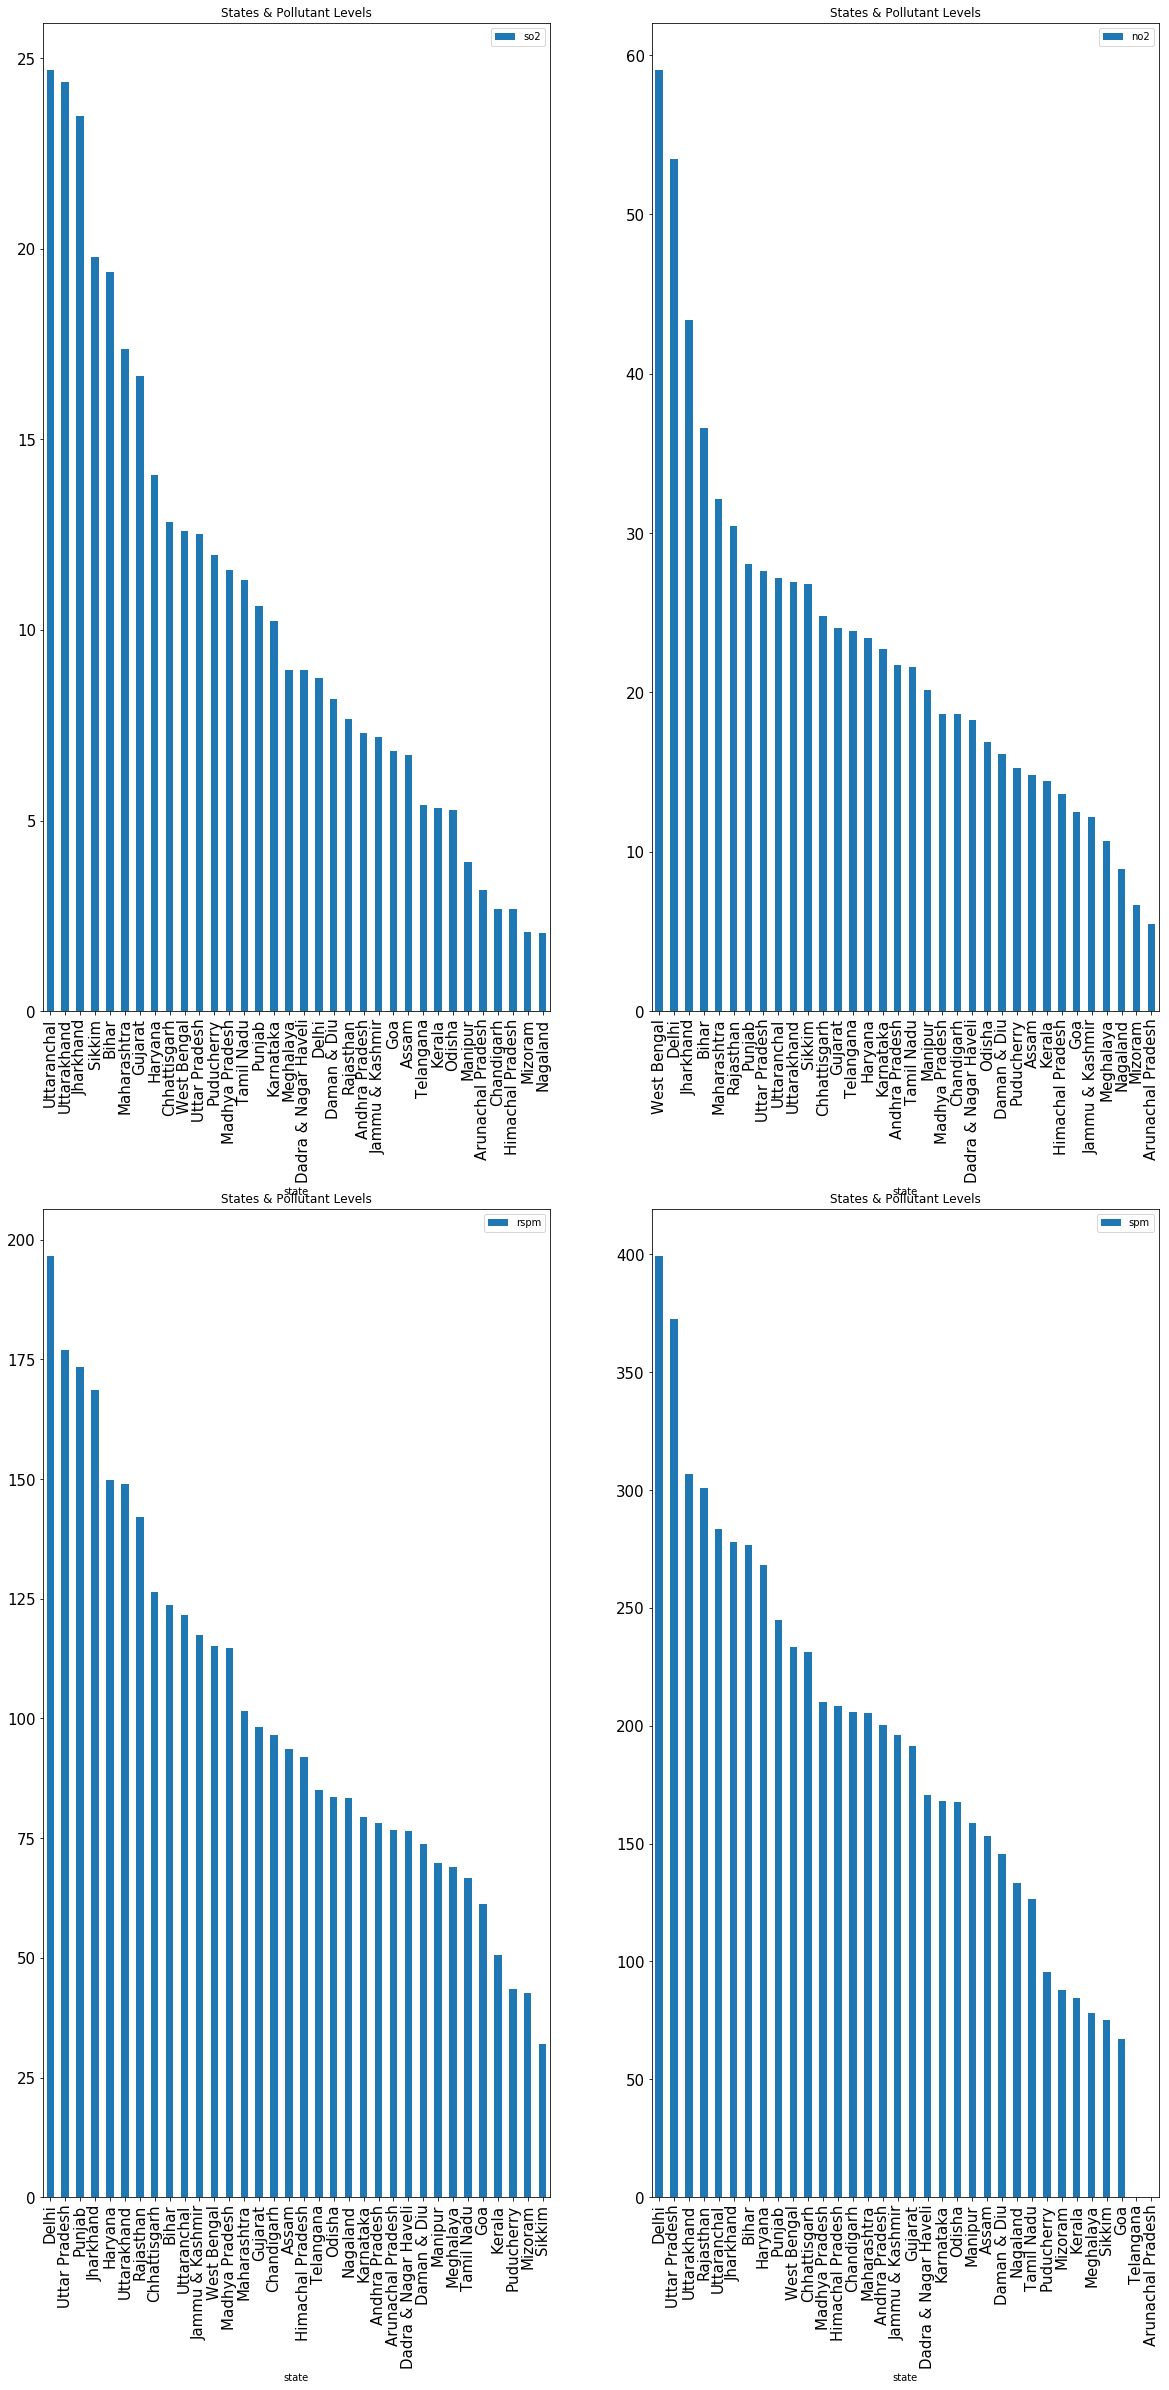

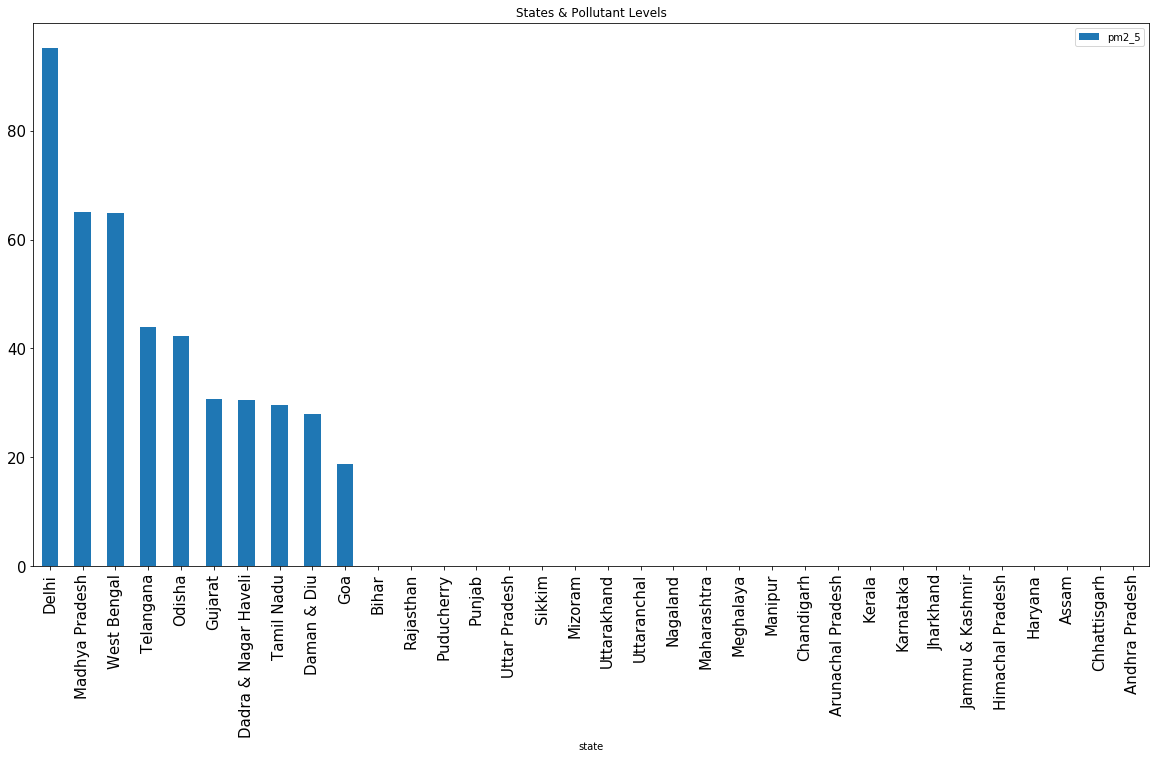

In [20]:


fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(40,40))
state_pollution = df[['state','so2']].groupby('state').mean()
state_pollution.reset_index(inplace = True)
state_pollution.sort_values('so2', ascending= False, inplace = True)
state_pollution.plot(kind = 'bar', figsize= (20,10), x = 'state', fontsize= 15, title = 'States & Pollutant Levels',ax=axes[0][0])

state_pollution_no2 = df[['state','no2']].groupby('state').mean()
state_pollution_no2.reset_index(inplace = True)
state_pollution_no2.sort_values('no2', ascending= False, inplace = True)
state_pollution_no2.plot(kind = 'bar', figsize= (20,10), x = 'state', fontsize= 15, title = 'States & Pollutant Levels',ax=axes[0][1])

state_pollution_rspm = df[['state','rspm']].groupby('state').mean()
state_pollution_rspm.reset_index(inplace = True)
state_pollution_rspm.sort_values('rspm', ascending= False, inplace = True)
state_pollution_rspm.plot(kind = 'bar', figsize= (20,40), x = 'state', fontsize= 15, title = 'States & Pollutant Levels',ax=axes[1][0])


state_pollution_spm = df[['state','spm']].groupby('state').mean()
state_pollution_spm.reset_index(inplace = True)
state_pollution_spm.sort_values('spm', ascending= False, inplace = True)
state_pollution_spm.plot(kind = 'bar', figsize= (20,40), x = 'state', fontsize= 15, title = 'States & Pollutant Levels',ax=axes[1][1])


state_pollution = df[['state','pm2_5']].groupby('state').mean()
state_pollution.reset_index(inplace = True)
state_pollution.sort_values('pm2_5', ascending= False, inplace = True)
state_pollution.plot(kind = 'bar', figsize= (20,10), x = 'state', fontsize= 15, title = 'States & Pollutant Levels')

plt.show()

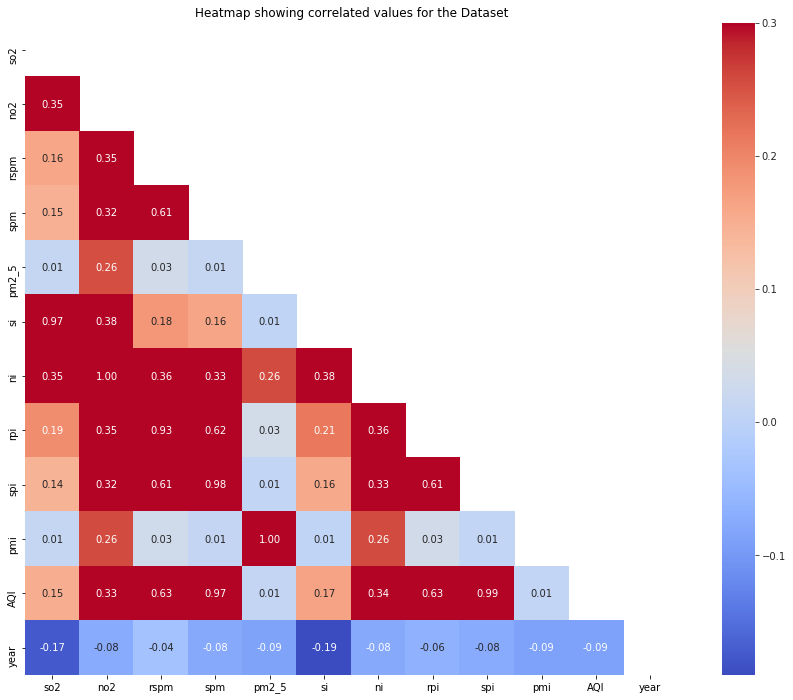

In [21]:
#correlation
# Heatmap
df.corr()
plt.figure(figsize=(16,12))
ax=plt.axes()
mask = np.zeros_like(df.iloc[:,:].corr())
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(data=df.iloc[:,:].corr(), mask=mask, vmax=.3, annot=True,fmt='.2f', square=True, cmap='coolwarm')
    
ax.set_title('Heatmap showing correlated values for the Dataset')
plt.show()

### AQI by State and Year

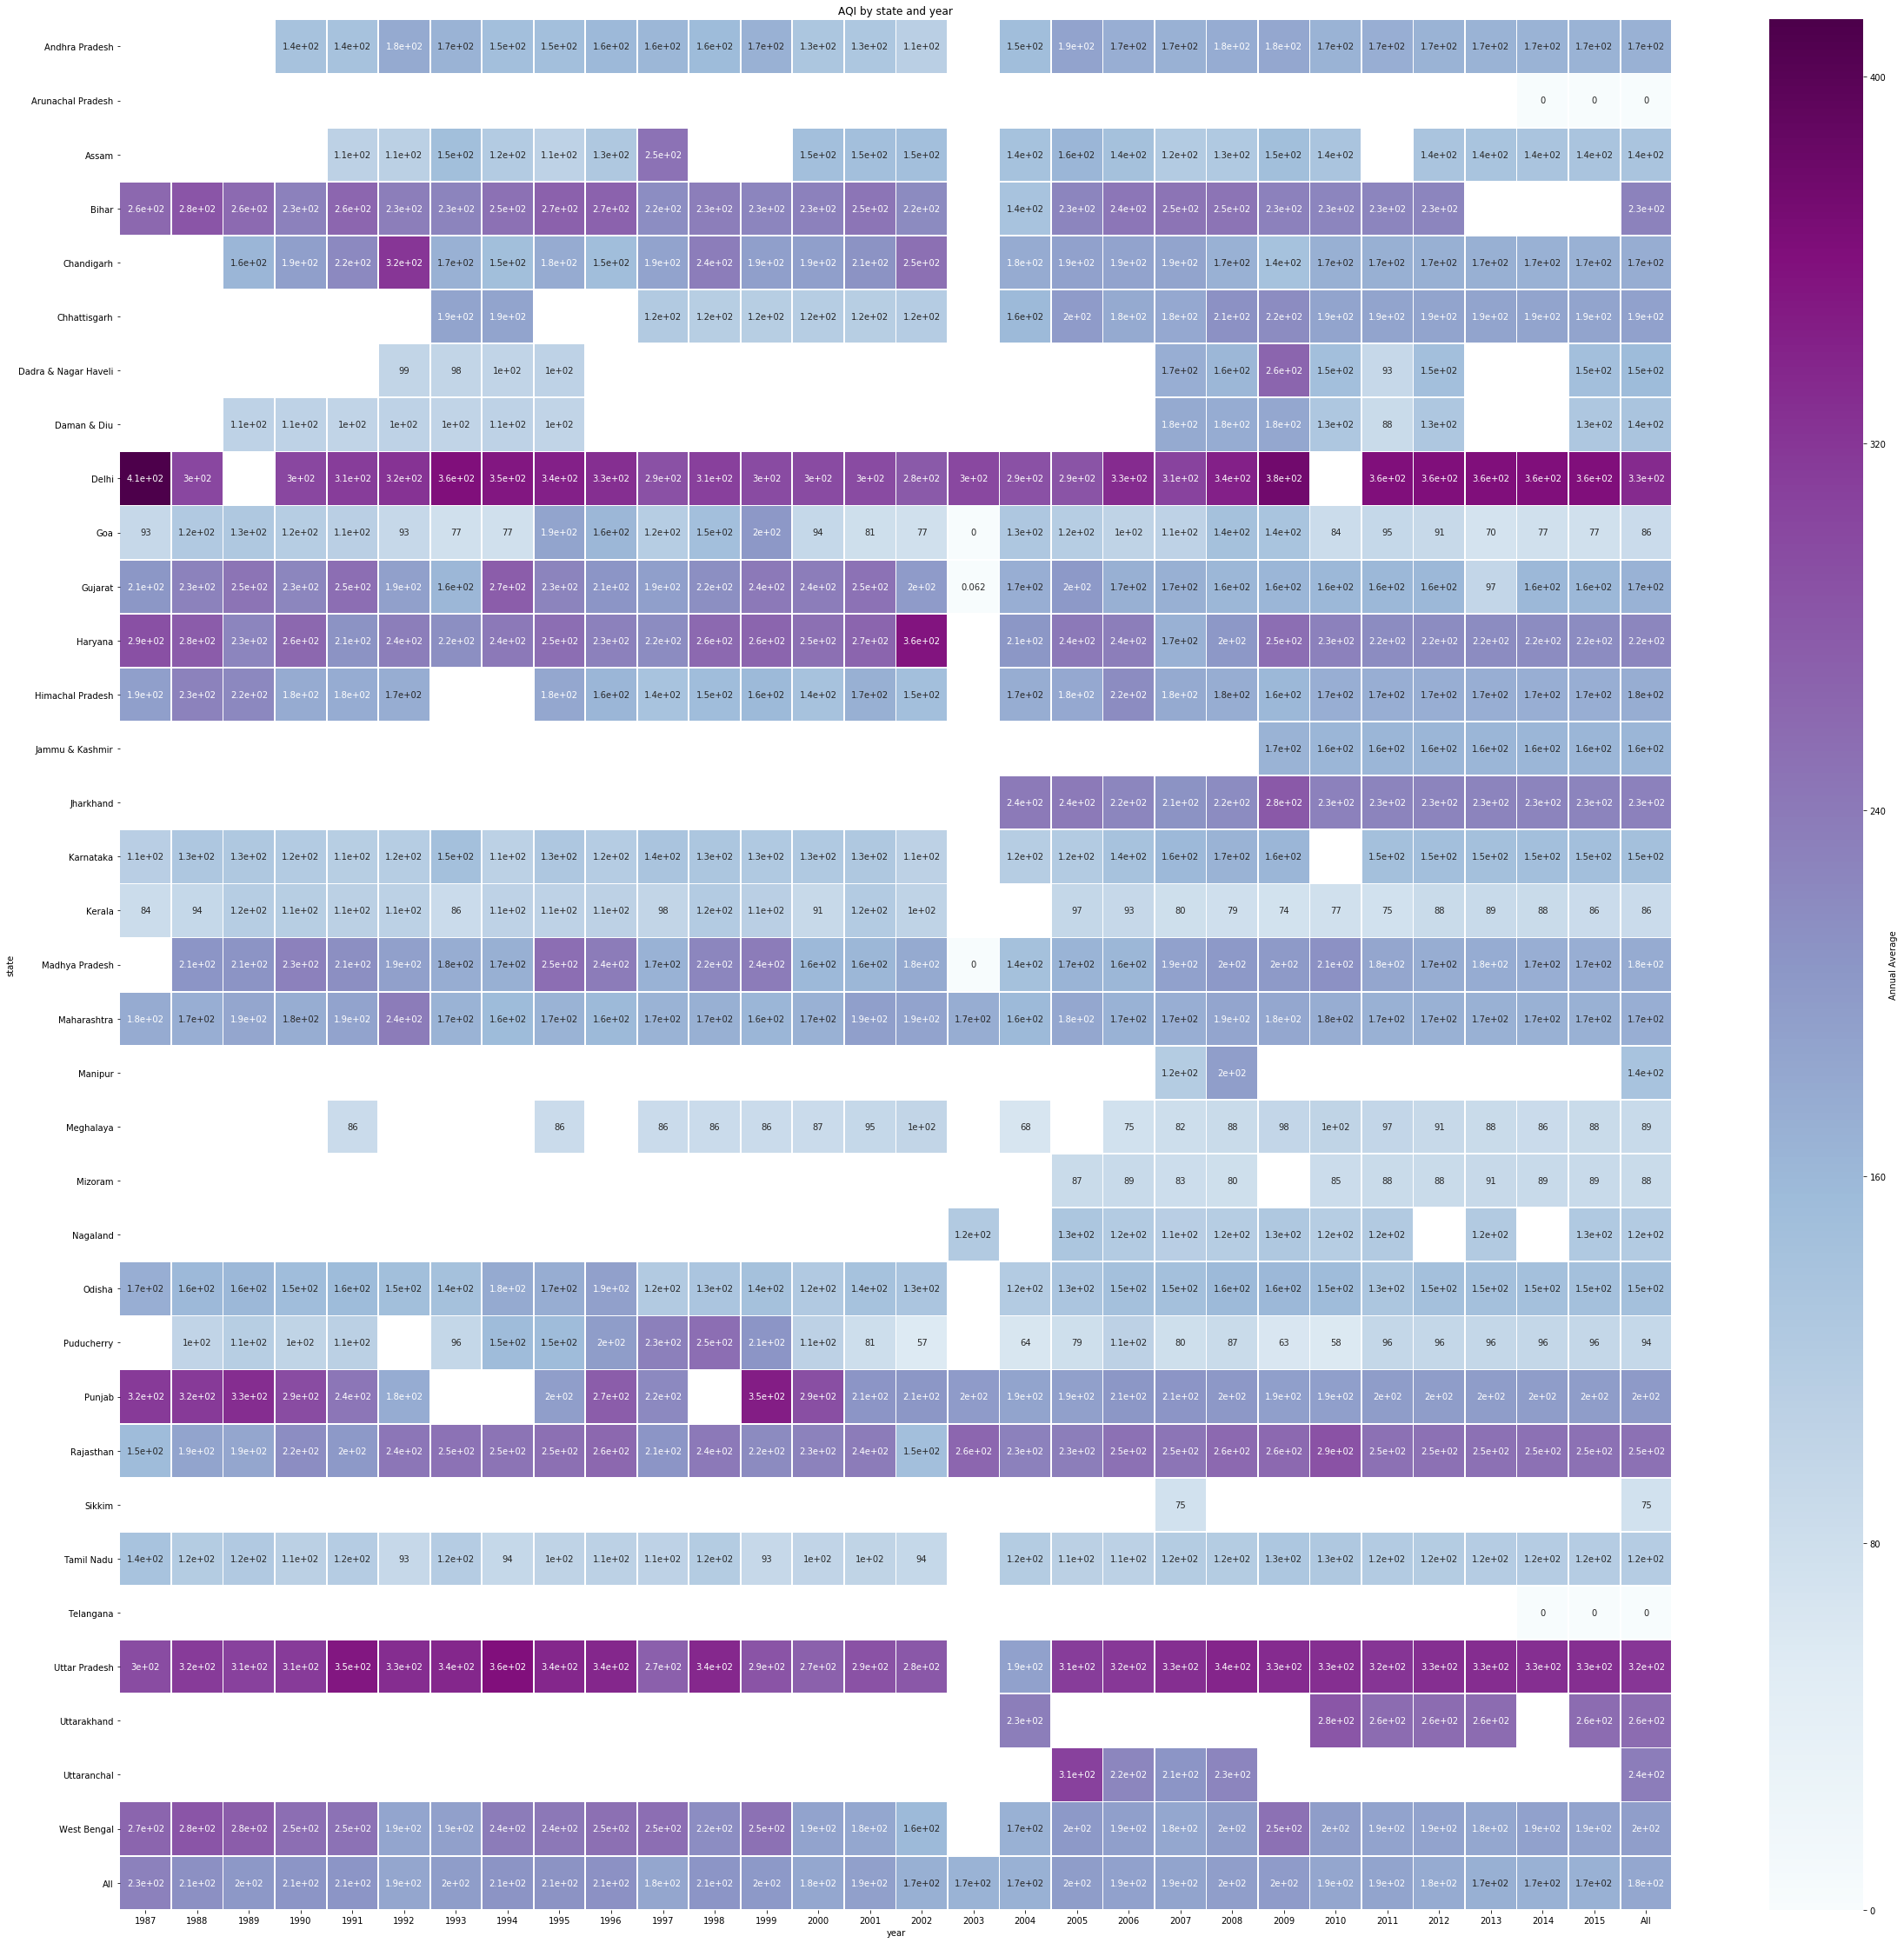

In [22]:
#Heatmap Pivot with State as Row, Year as Col, AQI as Value
df['date'] = pd.to_datetime(df['date'],format='%Y-%m-%d')
df['year'] = df['date'].dt.year # year
df['year'] = df['year'].fillna(0.0).astype(int)
df = df[(df['year']>0)]
f, ax = plt.subplots(figsize=(40,40))
ax.set_title('{} by state and year'.format('AQI'))
sns.heatmap(df.pivot_table('AQI', index='state',
                columns=['year'],aggfunc='mean',margins=True),
                annot=True,cmap="BuPu", linewidths=.75, ax=ax,
                cbar_kws={'label': 'Annual Average'})
plt.show()

In [23]:
df['state_label'] = df['state'].astype('category')
cat_columns = df.select_dtypes(['category']).columns
df[cat_columns] = df[cat_columns].apply(lambda x: x.cat.codes)

In [24]:
df["type_label"]=df["type"].astype(str)
df["type_label"] = np.where(df["type"].str.contains('Residential, Rural and other Areas'), 1, 0)


In [25]:
df.head()

,state,location,type,so2,no2,rspm,spm,pm2_5,date,si,ni,rpi,spi,pmi,AQI,year,state_label,type_label
0,Andhra Pradesh,Hyderabad,"Residential, Rural and other Areas",4.8,17.4,78.182824,200.260378,0.0,1990-02-01,6.000,21.750,97.72853,166.840252,0.0,166.840252,1990,0,1
1,Andhra Pradesh,Hyderabad,Industrial Area,3.1,7.0,78.182824,200.260378,0.0,1990-02-01,3.875,8.750,97.72853,166.840252,0.0,166.840252,1990,0,0
2,Andhra Pradesh,Hyderabad,"Residential, Rural and other Areas",6.2,28.5,78.182824,200.260378,0.0,1990-02-01,7.750,35.625,97.72853,166.840252,0.0,166.840252,1990,0,1
3,Andhra Pradesh,Hyderabad,"Residential, Rural and other Areas",6.3,14.7,78.182824,200.260378,0.0,1990-03-01,7.875,18.375,97.72853,166.840252,0.0,166.840252,1990,0,1
4,Andhra Pradesh,Hyderabad,Industrial Area,4.7,7.5,78.182824,200.260378,0.0,1990-03-01,5.875,9.375,97.72853,166.840252,0.0,166.840252,1990,0,0


### LOGISTIC REGRESSION

In [26]:
def AQI_Range(x):
    if x<=50:
        return "Good"
    elif x>50 and x<=100:
        return "Moderate"
    elif x>100 and x<=200:
        return "Unhealthy for sensitive groups"
    elif x>200 and x<=300:
        return "Unhealthy"
    elif x>300 and x<=400:
        return "Very unhealthy"
    elif x>400:
        return "Hazardous"

df['AQI_Range'] = df['AQI'] .apply(AQI_Range)
df.head()

,state,location,type,so2,no2,rspm,spm,pm2_5,date,si,ni,rpi,spi,pmi,AQI,year,state_label,type_label,AQI_Range
0,Andhra Pradesh,Hyderabad,"Residential, Rural and other Areas",4.8,17.4,78.182824,200.260378,0.0,1990-02-01,6.000,21.750,97.72853,166.840252,0.0,166.840252,1990,0,1,Unhealthy for sensitive groups
1,Andhra Pradesh,Hyderabad,Industrial Area,3.1,7.0,78.182824,200.260378,0.0,1990-02-01,3.875,8.750,97.72853,166.840252,0.0,166.840252,1990,0,0,Unhealthy for sensitive groups
2,Andhra Pradesh,Hyderabad,"Residential, Rural and other Areas",6.2,28.5,78.182824,200.260378,0.0,1990-02-01,7.750,35.625,97.72853,166.840252,0.0,166.840252,1990,0,1,Unhealthy for sensitive groups
3,Andhra Pradesh,Hyderabad,"Residential, Rural and other Areas",6.3,14.7,78.182824,200.260378,0.0,1990-03-01,7.875,18.375,97.72853,166.840252,0.0,166.840252,1990,0,1,Unhealthy for sensitive groups
4,Andhra Pradesh,Hyderabad,Industrial Area,4.7,7.5,78.182824,200.260378,0.0,1990-03-01,5.875,9.375,97.72853,166.840252,0.0,166.840252,1990,0,0,Unhealthy for sensitive groups


### Table Overview:- AQI_Range is converted to AQI_Label according to its 5 types using cat coding

In [27]:
df['AQI_label'] = df['AQI_Range'].astype('category')
cat_columns = df.select_dtypes(['category']).columns
df[cat_columns] = df[cat_columns].apply(lambda x: x.cat.codes)

df.head()

,state,location,type,so2,no2,rspm,spm,pm2_5,date,si,ni,rpi,spi,pmi,AQI,year,state_label,type_label,AQI_Range,AQI_label
0,Andhra Pradesh,Hyderabad,"Residential, Rural and other Areas",4.8,17.4,78.182824,200.260378,0.0,1990-02-01,6.000,21.750,97.72853,166.840252,0.0,166.840252,1990,0,1,Unhealthy for sensitive groups,4
1,Andhra Pradesh,Hyderabad,Industrial Area,3.1,7.0,78.182824,200.260378,0.0,1990-02-01,3.875,8.750,97.72853,166.840252,0.0,166.840252,1990,0,0,Unhealthy for sensitive groups,4
2,Andhra Pradesh,Hyderabad,"Residential, Rural and other Areas",6.2,28.5,78.182824,200.260378,0.0,1990-02-01,7.750,35.625,97.72853,166.840252,0.0,166.840252,1990,0,1,Unhealthy for sensitive groups,4
3,Andhra Pradesh,Hyderabad,"Residential, Rural and other Areas",6.3,14.7,78.182824,200.260378,0.0,1990-03-01,7.875,18.375,97.72853,166.840252,0.0,166.840252,1990,0,1,Unhealthy for sensitive groups,4
4,Andhra Pradesh,Hyderabad,Industrial Area,4.7,7.5,78.182824,200.260378,0.0,1990-03-01,5.875,9.375,97.72853,166.840252,0.0,166.840252,1990,0,0,Unhealthy for sensitive groups,4


In [28]:
df['AQI_label'].unique()

array([4, 2, 3, 5, 1, 0], dtype=int64)

### AQI_Range is converted to AQI_Range_Binary according to its 5 types using custom coding. Since for logistic we require binary categorical values only so we need to use either one hot encoding or custom coding .

In [29]:
def AQI_Range_Binary_Label(x):
    if x<=200:
        return 0
    elif x>200:
        return 1
    
df['AQI_Range_Binary'] = df['AQI'] .apply(AQI_Range_Binary_Label)
df.head()

,state,location,type,so2,no2,rspm,spm,pm2_5,date,si,...,rpi,spi,pmi,AQI,year,state_label,type_label,AQI_Range,AQI_label,AQI_Range_Binary
0,Andhra Pradesh,Hyderabad,"Residential, Rural and other Areas",4.8,17.4,78.182824,200.260378,0.0,1990-02-01,6.000,...,97.72853,166.840252,0.0,166.840252,1990,0,1,Unhealthy for sensitive groups,4,0
1,Andhra Pradesh,Hyderabad,Industrial Area,3.1,7.0,78.182824,200.260378,0.0,1990-02-01,3.875,...,97.72853,166.840252,0.0,166.840252,1990,0,0,Unhealthy for sensitive groups,4,0
2,Andhra Pradesh,Hyderabad,"Residential, Rural and other Areas",6.2,28.5,78.182824,200.260378,0.0,1990-02-01,7.750,...,97.72853,166.840252,0.0,166.840252,1990,0,1,Unhealthy for sensitive groups,4,0
3,Andhra Pradesh,Hyderabad,"Residential, Rural and other Areas",6.3,14.7,78.182824,200.260378,0.0,1990-03-01,7.875,...,97.72853,166.840252,0.0,166.840252,1990,0,1,Unhealthy for sensitive groups,4,0
4,Andhra Pradesh,Hyderabad,Industrial Area,4.7,7.5,78.182824,200.260378,0.0,1990-03-01,5.875,...,97.72853,166.840252,0.0,166.840252,1990,0,0,Unhealthy for sensitive groups,4,0


In [30]:
df['AQI_Range_Binary'].unique()
df.head()

,state,location,type,so2,no2,rspm,spm,pm2_5,date,si,...,rpi,spi,pmi,AQI,year,state_label,type_label,AQI_Range,AQI_label,AQI_Range_Binary
0,Andhra Pradesh,Hyderabad,"Residential, Rural and other Areas",4.8,17.4,78.182824,200.260378,0.0,1990-02-01,6.000,...,97.72853,166.840252,0.0,166.840252,1990,0,1,Unhealthy for sensitive groups,4,0
1,Andhra Pradesh,Hyderabad,Industrial Area,3.1,7.0,78.182824,200.260378,0.0,1990-02-01,3.875,...,97.72853,166.840252,0.0,166.840252,1990,0,0,Unhealthy for sensitive groups,4,0
2,Andhra Pradesh,Hyderabad,"Residential, Rural and other Areas",6.2,28.5,78.182824,200.260378,0.0,1990-02-01,7.750,...,97.72853,166.840252,0.0,166.840252,1990,0,1,Unhealthy for sensitive groups,4,0
3,Andhra Pradesh,Hyderabad,"Residential, Rural and other Areas",6.3,14.7,78.182824,200.260378,0.0,1990-03-01,7.875,...,97.72853,166.840252,0.0,166.840252,1990,0,1,Unhealthy for sensitive groups,4,0
4,Andhra Pradesh,Hyderabad,Industrial Area,4.7,7.5,78.182824,200.260378,0.0,1990-03-01,5.875,...,97.72853,166.840252,0.0,166.840252,1990,0,0,Unhealthy for sensitive groups,4,0


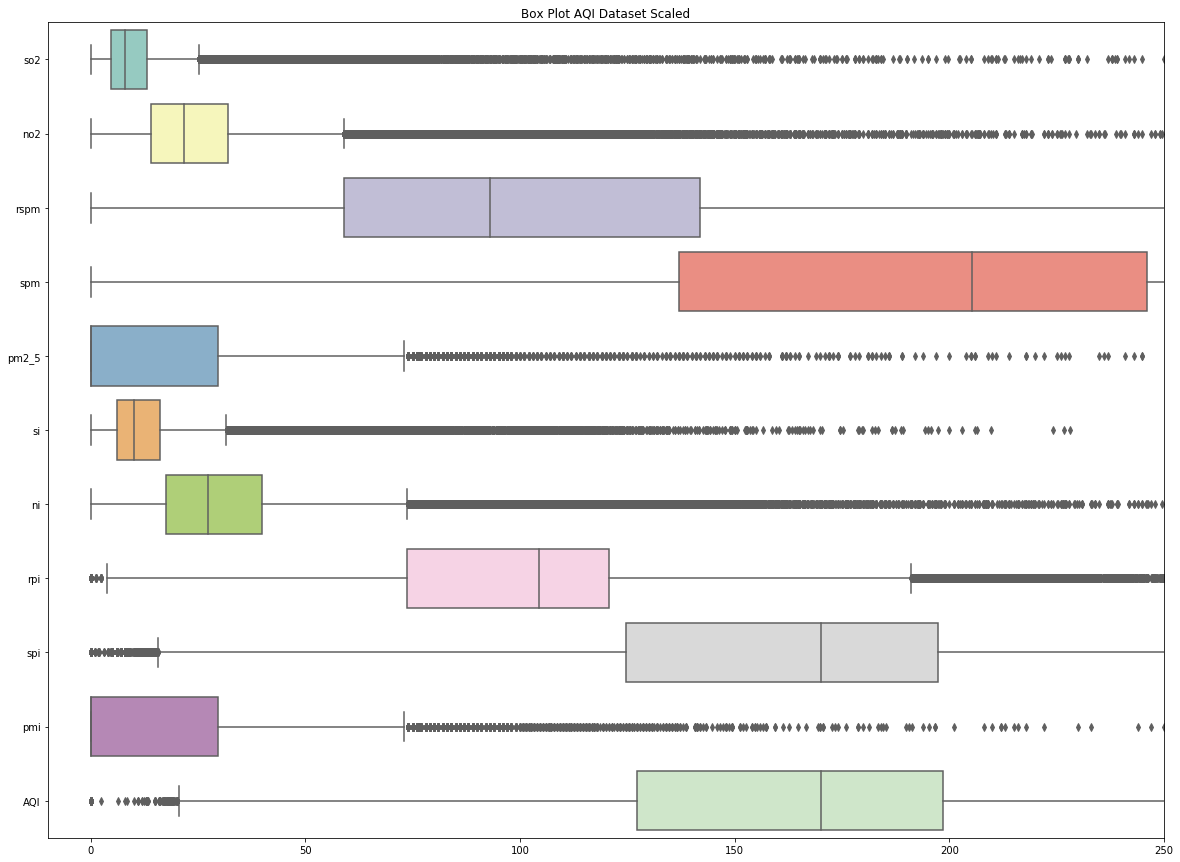

In [31]:
# Box Plot
dataset_box=df.drop(['state', 'location', 'date','state_label',
       'type_label','type','AQI_label','AQI_Range_Binary','year','AQI_Range'],axis=1)
f, ax = plt.subplots(figsize=(20, 15))

ax.set_facecolor('#FFFFFF')
plt.title("Box Plot AQI Dataset Scaled")
ax.set(xlim=(-10, 250))
ax = sns.boxplot(data = dataset_box, 
  orient = 'h', 
  palette = 'Set3')

In [32]:
# Following gives us the list of predictors that we need to rank in 
# order to see which variables we should use for our logistic model
predictor_names=dataset_box.columns.get_values()
predictor_names=predictor_names.tolist()
predictor_names.pop()
predictor_names


['so2', 'no2', 'rspm', 'spm', 'pm2_5', 'si', 'ni', 'rpi', 'spi', 'pmi']

### Dictionary of predictors that have been ranked in order to see which variables we should use for our logistic model.I am using median as to rank the predictors.

In [33]:
def rank_predictors(dat,l,f='AQI_Range_Binary'):
    rank={}
    max_vals=dat.max()
    median_vals=dat.groupby(f).median()  # using the median 
    for p in l:
        score=np.abs((median_vals[p][1]-median_vals[p][0])/max_vals[p])
        rank[p]=score
    return rank
cat_rank=rank_predictors(df,predictor_names) 
cat_rank

{'so2': 0.0022002200220021992,
 'no2': 0.012557077625570776,
 'rspm': 0.013318464572002605,
 'spm': 0.05828402366863905,
 'pm2_5': 0.0,
 'si': 0.007971303308090873,
 'ni': 0.017259414225941423,
 'rpi': 0.030184097703318313,
 'spi': 0.16236259814418275,
 'pmi': 0.0}

In [34]:
# Take the top predictors based on mean difference
cat_rank=sorted(cat_rank.items(), key=lambda x: x[1],reverse= True)

ranked_predictors=[]
for f in cat_rank:
    ranked_predictors.append(f[0])
ranked_predictors

['spi', 'spm', 'rpi', 'ni', 'rspm', 'no2', 'si', 'so2', 'pm2_5', 'pmi']

In [35]:
data_log=df.drop(['state','type','date','location'],axis=1)


In [36]:
def logistic_regression(x,y):
    x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.25,random_state=0)
    sc = StandardScaler()
    
    # Feature scaling
    x_train = sc.fit_transform(x_train)
    x_test = sc.fit_transform(x_test)
    
    #Fitting logistic regression to the training set
    classifier = LogisticRegression(random_state = 0)
    classifier.fit(x_train,y_train)    
    
    # Logistic regression cross validation
    k_fold = KFold(n_splits=10, shuffle=True, random_state=0)
    cvs=cross_val_score(classifier, x_train, y_train, cv=k_fold).mean()
    print("KfoldCrossVal mean score using Logistic regression is %s \n"%cvs)
    
    print("Logistic Analysis Report")
    y_pred = classifier.predict(x_test)
    print(classification_report(y_test,y_pred))
    print(y_pred)
    #Accuracy score
    print ("Accuracy Score:%.2f" % metrics.accuracy_score(y_test,classifier.predict(x_test)))
    #probabilty of dependent variable
    y_pred_proba = classifier.predict_proba(x_test)[::,1]
    print('Probabilty of dependent variable')
    print(y_pred_proba.mean())
    fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
    auc = metrics.roc_auc_score(y_test, y_pred_proba)
    plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
    plt.plot([0, 1], [0, 1],'r--')
    plt.legend(loc=4)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()




In [37]:
def logit_summary(y,X):
    logit_model=sm.Logit(y,X)
    result=logit_model.fit()
    print("Model Summary")
    print(result.summary2())

KfoldCrossVal mean score using Logistic regression is 0.9946083391444249 

Logistic Analysis Report
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     81957
           1       1.00      0.98      0.99     26977

    accuracy                           0.99    108934
   macro avg       0.99      0.99      0.99    108934
weighted avg       0.99      0.99      0.99    108934

[0 1 1 ... 1 1 1]
Accuracy Score:0.99
Probabilty of dependent variable
0.24833014795101904


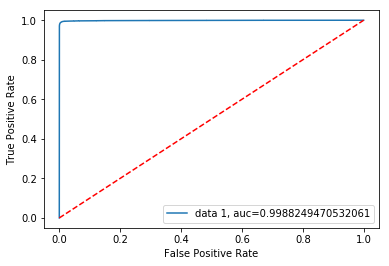

Optimization terminated successfully.
         Current function value: 0.022468
         Iterations 13
Model Summary
                          Results: Logit
Model:              Logit            Pseudo R-squared: 0.960      
Dependent Variable: AQI_Range_Binary AIC:              19606.5040 
Date:               2020-04-04 16:34 BIC:              19749.3062 
No. Observations:   435735           Log-Likelihood:   -9790.3    
Df Model:           12               LL-Null:          -2.4395e+05
Df Residuals:       435722           LLR p-value:      0.0000     
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     13.0000                                       
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
so2            0.0150    0.0024    6.1281  0.0000   0.0102   0.0198
no2            0.3855    0.0140   

In [40]:
data_log_1=df.drop(['state','type','date','location','AQI_label','AQI_Range','AQI','AQI_Range_Binary'],axis=1)
x=data_log_1.iloc[:,:]
y=data_log.iloc[:,16]

logistic_regression(x,y)
logit_summary(y,x)

In [41]:
#Logistic Regression Model 2
data_log_2=df.drop(['state','type','date','location','AQI_Range','type_label','AQI_label','AQI'],axis=1)

KfoldCrossVal mean score using Logistic regression is 0.6942481836492421 

Logistic Analysis Report
              precision    recall  f1-score   support

           0       0.70      0.81      0.75     62625
           1       0.68      0.54      0.60     46309

    accuracy                           0.70    108934
   macro avg       0.69      0.68      0.68    108934
weighted avg       0.69      0.70      0.69    108934

[1 0 0 ... 0 0 0]
Accuracy Score:0.70
Probabilty of dependent variable
0.4226086683580408


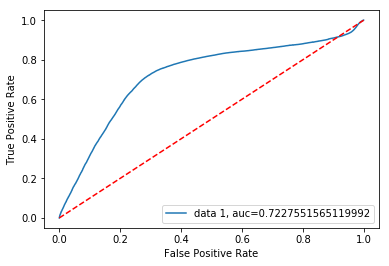

Optimization terminated successfully.
         Current function value: 0.668028
         Iterations 5
Model Summary
                          Results: Logit
Model:              Logit            Pseudo R-squared: 0.019      
Dependent Variable: type_label       AIC:              582192.3540
Date:               2020-04-04 16:36 BIC:              582335.1562
No. Observations:   435735           Log-Likelihood:   -2.9108e+05
Df Model:           12               LL-Null:          -2.9687e+05
Df Residuals:       435722           LLR p-value:      0.0000     
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     5.0000                                        
------------------------------------------------------------------
                   Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
------------------------------------------------------------------
so2                0.0092   0.0013   6.9845 0.0000  0.0066  0.0118
no2                0.0631   0.0034  18.

In [42]:
x=data_log_2.iloc[:,:]
y=df['type_label']
logistic_regression(x,y)
logit_summary(y,x)

KfoldCrossVal mean score using Logistic regression is 0.5841200051220251 

Logistic Analysis Report
              precision    recall  f1-score   support

           0       0.59      0.90      0.71     62625
           1       0.52      0.16      0.24     46309

    accuracy                           0.58    108934
   macro avg       0.56      0.53      0.48    108934
weighted avg       0.56      0.58      0.51    108934

[0 0 0 ... 0 0 0]
Accuracy Score:0.58
Probabilty of dependent variable
0.42254136101836987


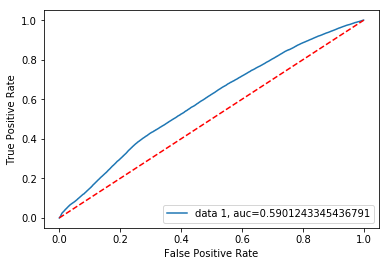

Optimization terminated successfully.
         Current function value: 0.669728
         Iterations 5
Model Summary
                          Results: Logit
Model:              Logit            Pseudo R-squared: 0.017      
Dependent Variable: type_label       AIC:              583668.1702
Date:               2020-04-04 16:37 BIC:              583778.0181
No. Observations:   435735           Log-Likelihood:   -2.9182e+05
Df Model:           9                LL-Null:          -2.9687e+05
Df Residuals:       435725           LLR p-value:      0.0000     
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     5.0000                                        
--------------------------------------------------------------------
           Coef.    Std.Err.      z       P>|z|     [0.025    0.975]
--------------------------------------------------------------------
so2        0.0090     0.0013     6.7608   0.0000    0.0064    0.0116
no2        0.0594     0.0033   

In [43]:
# Logistic Regression Model 3
x=df[predictor_names]
y=data_log.iloc[:,13]
logistic_regression(x,y)
logit_summary(y,x)

(87147, 4) (348588, 4) (87147,) (348588,)
r2_Square:0.98 
MSE:11.13 


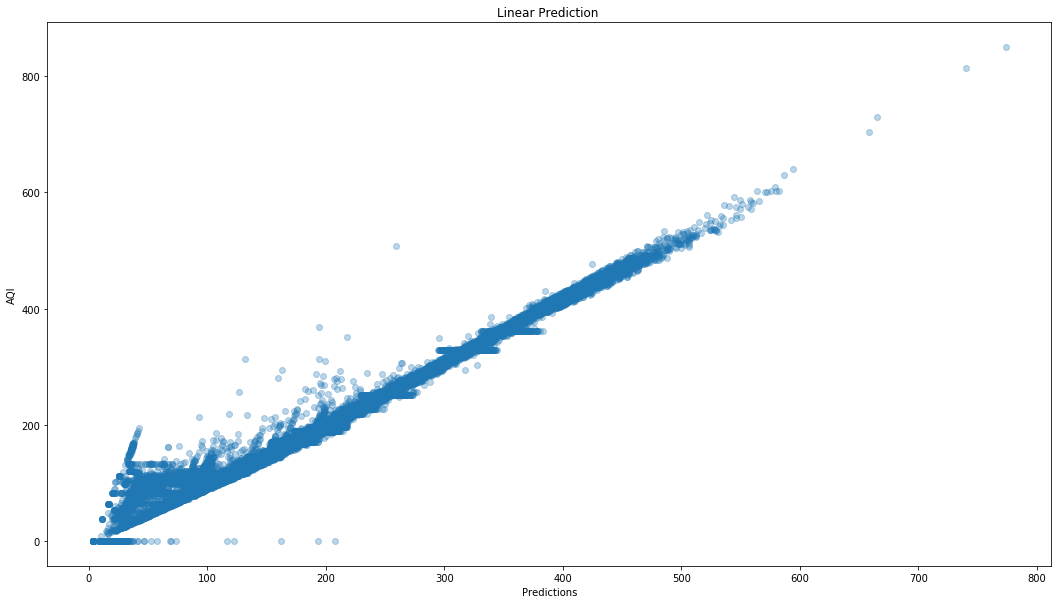

KfoldCrossVal mean score using Linear regression is 0.9848857286924144
                            OLS Regression Results                            
Dep. Variable:                    AQI   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                 3.668e+07
Date:                Sat, 04 Apr 2020   Prob (F-statistic):               0.00
Time:                        16:37:31   Log-Likelihood:            -1.2947e+06
No. Observations:              348588   AIC:                         2.589e+06
Df Residuals:                  348584   BIC:                         2.589e+06
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------

In [44]:
#Regularization:- l2

from sklearn.linear_model import Ridge
X_1=df[['si','ni','rpi','spi']]
y_1=df['AQI']
X_train, X_test, y_train, y_test = train_test_split(X_1,y_1, test_size=0.2)
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)

ridgeReg = Ridge(alpha=0.05, normalize=True)
ridgeReg.fit(X_train,y_train)
pred = ridgeReg.predict(X_test)

print(X_test.shape,X_train.shape,y_test.shape,y_train.shape)
print('r2_Square:%.2f '% r2_score(y_test, pred))
print('MSE:%.2f '% np.sqrt(mean_squared_error(y_test, pred)))

import statsmodels.formula.api as smf
regressor_OLS = smf.OLS(y_train, X_train).fit()

plt.figure(figsize=(18,10))
plt.scatter(pred,y_test,alpha = 0.3)
plt.xlabel('Predictions')
plt.ylabel('AQI')
plt.title("Linear Prediction ")
plt.show()
#cross validation    
Kfold = KFold(len(X_1), shuffle=True)
    #X_train = sc.fit_transform(X_train)
    #X_test = sc.transform(X_test)
print("KfoldCrossVal mean score using Linear regression is %s" %cross_val_score(ridgeReg,X_train,y_train,cv=10).mean())


print(regressor_OLS.summary())
